# Investigating the output of neural net embedding subnets - with 2D subnet output

## Aims

* To investigate the output of the hospital and clinical subnets of the embedding neural network.

* To examine the link between hospital subnet output and use of thrombolysis in hospitals - both the actual thrombolysis use, and the predicted thrombolysis use of a 10k set of patients passed through all hopsital moodels.

* To examine the link between the patient clinical feature subnet output and the use of thrombolysis, and the link between patient features and the clinical feature subnet output

## Neural Network structure

The model contains three subnets that take portions of the data. The output of these subnets is an n-dimensional vector. In this case the output is a 2D vector, that is each subnet is reduced to a single value output. The subnets created are for:

1. *Patient clinical data*: Age, gender, ethnicity, disability before stroke, stroke scale data. Pass through one hidden layer (with 2x neurons as input features) and then to single neuron with sigmoid activation.

2. *Pathway process data*: Times of arrival and scan, time of day, day of week. Pass through one hidden layer (with 2x neurons as input features) and then to single neuron with sigmoid activation.

3. *Hospital ID* (one-hot encoded): Connect input directly to single neuron with sigmoid activation.

The outputs of the three subnet outputs are then passed to a single neuron with sigmoid activation for final output.

![](./images/subnets_1.png)

## Fitting of model

The model has been pretrained (see the notebook *Modular TensorFlow model with 1D embedding - Train and save model for 10k patient subset*)

## Load libraries

In [1]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd

# sklearn for pre-processing
from sklearn.preprocessing import MinMaxScaler

# TensorFlow api model
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy

## Define function to scale data

Scale input data 0-1 (MinMax scaling).

In [2]:
def scale_data(X_train, X_test):
    """Scale data 0-1 based on min and max in training set"""
    
    # Initialise a new scaling object for normalising input data
    sc = MinMaxScaler()

    # Set up the scaler just on the training set
    sc.fit(X_train)

    # Apply the scaler to the training and test sets
    train_sc = sc.transform(X_train)
    test_sc = sc.transform(X_test)
    
    return train_sc, test_sc

## Get model outputs for test data

Get prediction probabilities for the test 10k training set. Training data is used only to scale test set X values.

This prediction run is used to check model, and get accuracy.

In [3]:
# Load data
train = pd.read_csv(f'../data/10k_training_test/cohort_10000_train.csv')
test = pd.read_csv(f'../data/10k_training_test/cohort_10000_test.csv')

all_test = test.copy()

# Get data subgroups
subgroups = pd.read_csv('../data/subnet.csv', index_col='Item')
# Get list of clinical items
clinical_subgroup = subgroups.loc[subgroups['Subnet']=='clinical']
clinical_subgroup = list(clinical_subgroup.index)
# Get list of pathway items
pathway_subgroup = subgroups.loc[subgroups['Subnet']=='pathway']
pathway_subgroup = list(pathway_subgroup.index)
# Get list of hospital items
hospital_subgroup = subgroups.loc[subgroups['Subnet']=='hospital']
hospital_subgroup = list(hospital_subgroup.index)

# OneHot encode stroke team
coded = pd.get_dummies(train['StrokeTeam'])
train = pd.concat([train, coded], axis=1)
train.drop('StrokeTeam', inplace=True, axis=1)
coded = pd.get_dummies(test['StrokeTeam'])
test = pd.concat([test, coded], axis=1)
test.drop('StrokeTeam', inplace=True, axis=1)

# Split into X, y
X_train_df = train.drop('S2Thrombolysis',axis=1) 
y_train_df = train['S2Thrombolysis']
X_test_df = test.drop('S2Thrombolysis',axis=1) 
y_test_df = test['S2Thrombolysis'] 

# Split train and test data by subgroups
X_train_patients = X_train_df[clinical_subgroup]
X_test_patients = X_test_df[clinical_subgroup]
X_train_pathway = X_train_df[pathway_subgroup]
X_test_pathway = X_test_df[pathway_subgroup]
X_train_hospitals = X_train_df[hospital_subgroup]
X_test_hospitals = X_test_df[hospital_subgroup]

# Convert to NumPy
X_train = X_train_df.values
X_test = X_test_df.values
y_train = y_train_df.values
y_test = y_test_df.values

# Scale data
X_train_patients_sc, X_test_patients_sc = \
    scale_data(X_train_patients, X_test_patients)

X_train_pathway_sc, X_test_pathway_sc = \
    scale_data(X_train_pathway, X_test_pathway)

X_train_hospitals_sc, X_test_hospitals_sc = \
    scale_data(X_train_hospitals, X_test_hospitals)

# Load model
path = './saved_models/2d_for_10k/'
filename = f'{path}model.h5'
model = keras.models.load_model(filename)

# Test model
probability = model.predict(
    [X_test_patients_sc, X_test_pathway_sc, X_test_hospitals_sc])
y_pred_test = probability >= 0.5
y_pred_test = y_pred_test.flatten()
accuracy_test = np.mean(y_pred_test == y_test)
print(f'Accuracy test {accuracy_test:0.3f}')

all_test['model_prob'] = probability.flatten()
all_test['prediction'] = y_pred_test

Accuracy test 0.843


## Get predictions for thrombolysis use of 10k set of patients at each hospital

Here we ask the counter-factual question - "what treatment would a patient be expected to receive at each of the 132 hospitals?".

Hospital is one-hot encoded as input to the hospital subnet. To make a prediction of treatment at different hospitals we change the one-hot encoding of the hospital when making prediction.

For each hospital we pass through the 10k test set, and record the proportion of the patients receiving thrombolysis at that hospital.

In [4]:
# Get number of hospitals
num_hospitals = len(X_test_hospitals_sc[0])
# Create test array for changing hospital ID
X_hospitals_alter = X_test_hospitals_sc.copy()
# List for all patient classifications at each hospital
patient_results = []

# Loop through setting hospital
hospital_results = []
for hosp in range(num_hospitals):
    # Set all hospitals to zero
    X_hospitals_alter[:,:] = 0
    # Set test hospital to 1
    X_hospitals_alter[:,hosp] = 1
    # Get probability of thrombolysis
    probability = model.predict(
        [X_test_patients_sc, X_test_pathway_sc, X_hospitals_alter])
    # Classify
    classified = probability >= 0.5
    # Get average thrombolysis (we are not stroring all individual results)
    thrombolysis = classified.mean()
    hospital_results.append(thrombolysis)
    patient_results.append(classified)

# Put results in DataFrame 
predicted_thrombolysis = pd.DataFrame()
predicted_thrombolysis['hospital'] = hospital_subgroup
predicted_thrombolysis['10k_thrombolysis'] = hospital_results

# Show DataFrame
predicted_thrombolysis

,hospital,10k_thrombolysis
0,AGNOF1041H,0.2886
1,AKCGO9726K,0.3829
2,AOBTM3098N,0.2320
3,APXEE8191H,0.2909
4,ATDID5461S,0.2728
...,...,...
127,YPKYH1768F,0.2620
128,YQMZV4284N,0.3341
129,ZBVSO0975W,0.2301
130,ZHCLE1578P,0.3126


In [5]:
patient_thromb_results = np.sum(patient_results, axis=0).flatten()
all_test['num_hosp_thrombolysing'] = patient_thromb_results
all_test

,StrokeTeam,S1AgeOnArrival,S1OnsetToArrival_min,S2RankinBeforeStroke,Loc,LocQuestions,LocCommands,BestGaze,Visual,FacialPalsy,...,S2StrokeType_Primary Intracerebral Haemorrhage,S2StrokeType_missing,S2TIAInLastMonth_No,S2TIAInLastMonth_No but,S2TIAInLastMonth_Yes,S2TIAInLastMonth_missing,S2Thrombolysis,model_prob,prediction,num_hosp_thrombolysing
0,LGNPK4211W,67.5,193.0,1,0,2.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,1,0,0.000038,False,0
1,LZGVG8257A,62.5,54.0,2,0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0.455021,False,36
2,DNOYM6465G,82.5,173.0,0,0,0.0,0.0,0.0,0.0,1.0,...,0,0,0,0,0,1,0,0.074149,False,0
3,ISIZF6614O,72.5,159.0,1,0,2.0,0.0,0.0,2.0,0.0,...,0,0,0,0,0,1,0,0.556605,True,113
4,NGKDE7265L,87.5,145.0,0,0,0.0,0.0,0.0,0.0,1.0,...,0,0,0,0,0,1,0,0.137400,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,NFBUF0424E,57.5,99.0,0,1,2.0,2.0,1.0,2.0,2.0,...,1,0,0,0,0,1,0,0.002355,False,0
9996,UJETD9177J,87.5,159.0,3,0,2.0,2.0,0.0,0.0,0.0,...,0,0,0,0,0,1,1,0.214499,False,1
9997,BICAW1125K,67.5,142.0,0,0,0.0,0.0,0.0,2.0,0.0,...,0,0,0,0,0,1,0,0.730262,True,132
9998,CYVHC2532V,72.5,101.0,0,0,0.0,0.0,0.0,0.0,1.0,...,0,0,0,0,0,1,0,0.000762,False,0


## Get subnet outputs

### Get hospital subnet output

In [6]:
results = []
for hosp in range(num_hospitals):
    # Set all hospitals to zero
    X_hospitals_alter[:,:] = 0
    # Set test hospital to 1
    X_hospitals_alter[:,hosp] = 1
    # Get hospital subnet output
    layer_name = 'hospital_encode'
    hospital_encode_model = keras.Model(
        inputs=model.input,outputs=model.get_layer(layer_name).output)
    hospital_encode_output = hospital_encode_model([
        X_test_patients_sc, X_test_pathway_sc, X_hospitals_alter])
    results.append(np.mean(hospital_encode_output.numpy(),axis=0))

results = np.array(results)
hospital_encoding = pd.DataFrame(index=hospital_subgroup)
hospital_encoding['hosp_encode_x'] = results[:, 0]
hospital_encoding['hosp_encode_y'] = results[:, 1]
all_test = all_test.merge(
    hospital_encoding, left_on='StrokeTeam', right_index=True, how='left')

### Get patient subnet output

In [7]:
# Get patient subnet output
layer_name = 'patient_encode'
patient_encode_model = keras.Model(
    inputs=model.input,outputs=model.get_layer(layer_name).output)
patient_encode_output = patient_encode_model([
    X_test_patients_sc, X_test_pathway_sc, X_test_hospitals_sc])
patient_encode_output = patient_encode_output.numpy()

In [8]:
patient_encode_output

array([[0.9715982 , 0.0169461 ],
       [0.28645337, 0.6916805 ],
       [0.22771867, 0.24591173],
       ...,
       [0.14738613, 0.97659886],
       [0.910986  , 0.4587859 ],
       [0.9470407 , 0.01368953]], dtype=float32)

In [9]:
all_test['patient_encode_x'] = patient_encode_output[:, 0]
all_test['patient_encode_y'] = patient_encode_output[:, 1]

### Get pathway subnet output

In [10]:
# Get patient subnet output
layer_name = 'pathway_encode'
pathway_encode_model = keras.Model(
    inputs=model.input,outputs=model.get_layer(layer_name).output)
pathway_encode_output = pathway_encode_model([
    X_test_patients_sc, X_test_pathway_sc, X_test_hospitals_sc])
pathway_encode_output = pathway_encode_output.numpy()

pathway_encode_output

array([[9.0462186e-30, 4.6191800e-02],
       [1.0000000e+00, 9.1275048e-01],
       [4.0270866e-23, 8.5490012e-01],
       ...,
       [1.0000000e+00, 9.2618495e-01],
       [1.8072895e-21, 2.0514728e-01],
       [1.0000000e+00, 9.5640117e-01]], dtype=float32)

In [11]:
all_test['pathway_encode_x'] = pathway_encode_output[:, 0]
all_test['pathway_encode_y'] = pathway_encode_output[:, 1]
all_test.to_csv('./output/2d_outputs.csv')
all_test

,StrokeTeam,S1AgeOnArrival,S1OnsetToArrival_min,S2RankinBeforeStroke,Loc,LocQuestions,LocCommands,BestGaze,Visual,FacialPalsy,...,S2Thrombolysis,model_prob,prediction,num_hosp_thrombolysing,hosp_encode_x,hosp_encode_y,patient_encode_x,patient_encode_y,pathway_encode_x,pathway_encode_y
0,LGNPK4211W,67.5,193.0,1,0,2.0,0.0,0.0,0.0,0.0,...,0,0.000038,False,0,0.994444,0.999999,0.971598,0.016946,9.046219e-30,0.046192
1,LZGVG8257A,62.5,54.0,2,0,0.0,0.0,0.0,0.0,0.0,...,0,0.455021,False,36,0.054258,0.999681,0.286453,0.691680,1.000000e+00,0.912750
2,DNOYM6465G,82.5,173.0,0,0,0.0,0.0,0.0,0.0,1.0,...,0,0.074149,False,0,0.000313,0.962226,0.227719,0.245912,4.027087e-23,0.854900
3,ISIZF6614O,72.5,159.0,1,0,2.0,0.0,0.0,2.0,0.0,...,0,0.556605,True,113,0.359619,0.999920,0.134090,0.811445,1.000000e+00,0.839783
4,NGKDE7265L,87.5,145.0,0,0,0.0,0.0,0.0,0.0,1.0,...,0,0.137400,False,0,0.000113,0.842160,0.935024,0.970843,1.000000e+00,0.926450
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,NFBUF0424E,57.5,99.0,0,1,2.0,2.0,1.0,2.0,2.0,...,0,0.002355,False,0,0.679200,0.999900,0.973709,0.005022,1.000000e+00,0.846838
9996,UJETD9177J,87.5,159.0,3,0,2.0,2.0,0.0,0.0,0.0,...,1,0.214499,False,1,0.000235,0.951178,0.063271,0.441744,5.232738e-21,0.836204
9997,BICAW1125K,67.5,142.0,0,0,0.0,0.0,0.0,2.0,0.0,...,0,0.730262,True,132,0.277610,0.999906,0.147386,0.976599,1.000000e+00,0.926185
9998,CYVHC2532V,72.5,101.0,0,0,0.0,0.0,0.0,0.0,1.0,...,0,0.000762,False,0,0.147991,0.999695,0.910986,0.458786,1.807289e-21,0.205147


## Comparing hospital subnet activation with thrombolysis use at each hospital

The hospital subnet outputs a single value (in the range 0-1) for each hospital.

Here we compare the hospital subnet output for each hospital with:

1. The actual use of thrombolysis for 10k test-set patients at their own hospital only.

2. The expected use of thrombolysis in the 10k test-set for each hospital. The 10k patient data set is passed through all hospital models (by changing the one-hot hospital encoding).

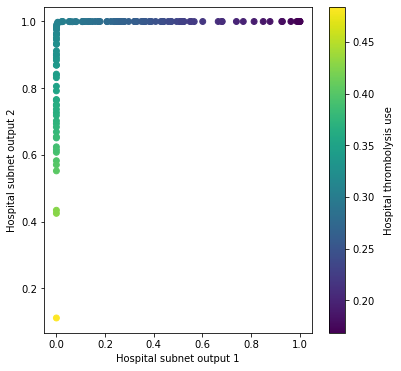

In [12]:
# Set up figure
fig = plt.figure(figsize=(6,6))

# Plot 1: actual vs subnet
ax1 = fig.add_subplot(111)
cmap = plt.cm.viridis
min_val = predicted_thrombolysis['10k_thrombolysis'].min()
max_val = predicted_thrombolysis['10k_thrombolysis'].max()
im = ax1.scatter(hospital_encoding['hosp_encode_x'],
            hospital_encoding['hosp_encode_y'],
            c=predicted_thrombolysis['10k_thrombolysis'],
            vmin=min_val, vmax=max_val, s=35, cmap=cmap)
cbar = plt.colorbar(im, ax=ax1)
cbar.set_label('Hospital thrombolysis use', rotation=90, labelpad=10)
ax1.set_xlabel('Hospital subnet output 1')
ax1.set_ylabel('Hospital subnet output 2')
plt.savefig('./output/hospital_subnet_scatter.jpg', dpi=300)
plt.show()

In this output, all hospitals appear to sit on $x=0$ or $y=1$, with use of thrombolysis in the hospital increasing along the $y$ axis and then the $x$ axis.

## Comparing clinical subnet activation with the number of hospitals that are predicted to give thrombolysis to each patient

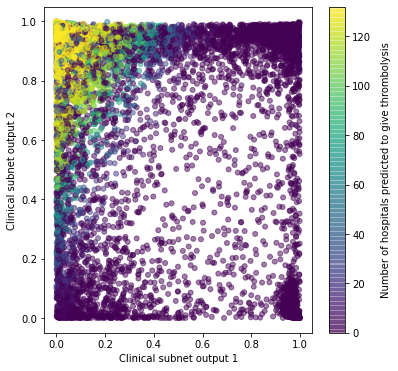

In [13]:
# Set up figure
fig = plt.figure(figsize=(6,6))

# Plot 1: actual vs subnet
cmap = plt.cm.viridis
ax1 = fig.add_subplot(111)
im = ax1.scatter(all_test['patient_encode_x'],
            all_test['patient_encode_y'],
            c=all_test['num_hosp_thrombolysing'],
            vmin=0, vmax=132, s=25, cmap=cmap, alpha=0.5)
cbar = plt.colorbar(im, ax=ax1)
cbar.set_label('Number of hospitals predicted to give thrombolysis', rotation=90, labelpad=10)
ax1.set_xlabel('Clinical subnet output 1')
ax1.set_ylabel('Clinical subnet output 2')
plt.savefig('./output/clinical_subnet_scatter.jpg', dpi=300)
plt.show()

The patients most likely to be given thrombolysis are those in the top left of the scatter plot ($x$ close to 0, and $y$ close to 1. Predicted use of thrombolysis falls as a function of distance from that corner. Use of thrombolysis will also be effected by pathway data, but this scatter plot shows a dominant effect of clinical subnet output.

Patients appear to cluster mostly towards the edges of the plot.

In the following analysis, we will look at the characteristics of patients in different parts of the scatter plot.

### Analysis by stroke type

Plot the location of stroke type by haemorrhage (red) or infarction (blue).

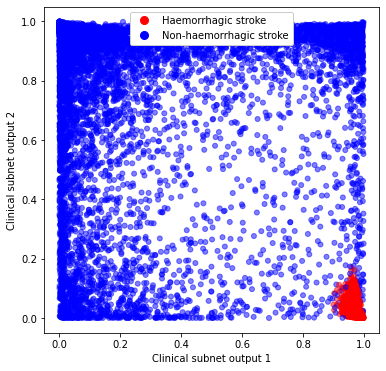

In [14]:
bleed = all_test['S2StrokeType_Primary Intracerebral Haemorrhage'] 

# Set up figure
cmap = plt.cm.bwr
fig = plt.figure(figsize=(6,6))

# Plot 1: actual vs subnet
ax1 = fig.add_subplot(111)
im = ax1.scatter(all_test['patient_encode_x'],
           all_test['patient_encode_y'],
           c=bleed,
        vmin=0, vmax=1, s=25, cmap=cmap, alpha=0.5)
#plt.colorbar(im, ax=ax1)
ax1.set_xlabel('Clinical subnet output 1')
ax1.set_ylabel('Clinical subnet output 2')

custom_lines = [Line2D([0], [0], color='r', marker='o', lw=0, markerfacecolor='r', markersize=8),
                Line2D([0], [0], color='b', marker='o', lw=0, markerfacecolor='b', markersize=8)]

plt.legend(custom_lines, ['Haemorrhagic stroke', 'Non-haemorrhagic stroke'],
          loc='upper center', framealpha=1)


plt.savefig('./output/clinical_subnet_scatter_stroke_type.jpg', dpi=300)
plt.show()

We observe that haemorrhagic stroke patients are clustered in one corner of the chart, suggesting that clinical subnet output may be used to compare similarity between patients (driven by reasons to give or not give thrombolysis).

## Summarise patients in corners of chart

Summarise key characteristics of patients in the four corners of the chart.

In [15]:
paient_encode_regions = pd.DataFrame()

# Low x and low y
mask = (all_test['patient_encode_x'] < 0.2) & (all_test['patient_encode_y'] < 0.2)
paient_encode_regions['low_x_low_y'] = all_test[mask].mean()

# Low x and high y
mask = (all_test['patient_encode_x'] < 0.2) & (all_test['patient_encode_y'] > 0.8)
paient_encode_regions['low_x_high_y'] = all_test[mask].mean()

# High x and low y
mask = (all_test['patient_encode_x'] > 0.8) & (all_test['patient_encode_y'] <0.2)
paient_encode_regions['high_x_low_y'] = all_test[mask].mean()

# High x and high y
mask = (all_test['patient_encode_x'] > 0.8) & (all_test['patient_encode_y'] > 0.8)
paient_encode_regions['high_x_high_y'] = all_test[mask].mean()

In [16]:
paient_encode_regions

,low_x_low_y,low_x_high_y,high_x_low_y,high_x_high_y
S1AgeOnArrival,83.731767,70.882673,75.556063,71.761321
S1OnsetToArrival_min,108.585089,103.129677,109.464960,122.270973
S2RankinBeforeStroke,2.871961,0.241918,1.139549,0.493690
Loc,0.769854,0.157646,0.671542,0.007424
LocQuestions,1.520259,0.779876,0.840951,0.030438
...,...,...,...,...
hosp_encode_y,0.912189,0.909141,0.917274,0.906201
patient_encode_x,0.066940,0.048527,0.966237,0.939780
patient_encode_y,0.072550,0.937993,0.029484,0.947498
pathway_encode_x,0.541331,0.716123,0.574025,0.598690


In [17]:
paient_encode_regions.to_csv('./output/paient_encode_regions.csv')

Show specific rows

In [18]:
rows_to_show = [
    'S2RankinBeforeStroke',
    'S2NihssArrival',
    'S2StrokeType_Primary Intracerebral Haemorrhage',
    'num_hosp_thrombolysing']

paient_encode_regions.loc[rows_to_show].round(2)

,low_x_low_y,low_x_high_y,high_x_low_y,high_x_high_y
S2RankinBeforeStroke,2.87,0.24,1.14,0.49
S2NihssArrival,18.30,11.81,12.55,0.94
S2StrokeType_Primary Intracerebral Haemorrhage,0.00,0.00,0.95,0.00
num_hosp_thrombolysing,3.91,102.04,0.00,0.01


We see different types of patients in different quadrants of the clinical subnet output scatter chart:

* *Low x and low y*: Largely non-thrombolysed patients with infarction stroke, and severe stroke and/or higher disability before stroke.

* *Low x and high y*: Largely thrombolysed patients.

* *High x and low y*: Largely non-thrombolysed patients with haemorrhagic stroke.

* *High x and high y*: Largely non-thrombolysed patients with infarction stroke and very mild stroke.

## Observations

2D clinical subnet analysis allows leads to potentially useful embedding/encoding of patients whereby similar patients are clustered together. 